# Vehicle-agnostic scene processing for information embedding.

Input data: processed vehicle groups from the highD dataset. See dataviz.ipynb for more info.

In [2]:
import cProfile
import h5py
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import os
import seaborn as sns

from copy import copy
from IPython.display import HTML
from matplotlib.patches import Rectangle, Ellipse
from pprint import pprint
from rich import print
from sys import platform
from time import time

from read_csv import read_groups

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.color_palette("hls", 8)

def print_bl():
    print("\n")

%matplotlib widget

In [3]:
if platform == 'darwin':
    dataset_location = "/Users/lmiguelmartinez/Tesis/datasets/highD/groups_1000ms/"
else:
    dataset_location = "/home/lmmartinez/Tesis/datasets/highD/groups_1000ms/"
dataset_index = 1 #between 1 and 60
df_groups_list = read_groups(dataset_location + str(dataset_index).zfill(2) + "_groups.csv")

In [47]:
class PotentialField:
    def __init__(self, radius_x, radius_y, step_x, step_y, df_group_list):
        self.rx, self.ry = radius_x, radius_y
        self.sx, self.sy = step_x, step_y
        self.df_group_list = df_group_list

        self.grid = self.initialize_grid()
        self.field_list = [None] * len(self.df_group_list)

    def initialize_grid(self):
        #calculate grid size
        self.num_x = int(2*self.rx / self.sx) + 1
        self.num_y = int(2*self.ry / self.sy) + 1
        self.grid = np.zeros([self.num_y, self.num_x], dtype = np.float32) #x dimension is rows, y dimension is columns
        self.x_pos, self.y_pos = np.linspace(-self.rx, self.rx, self.num_x), np.linspace(-self.ry, self.ry, self.num_y) #x and y interchanged so x is the horizontal dimension, and y is the vertical dimension
        print("Initialized grid of shape: {}".format(self.grid.shape))
        return self.grid

    def group_to_list(self, group):
        self.vehicle_list = group.to_dict(orient='records')
        for idx, vehicle in enumerate(self.vehicle_list):
            for k, v in vehicle.items():
                self.vehicle_list[idx][k] = float(v)
        return self.vehicle_list
    
    def get_field_value(self, x, y, a, b, c, k):
        local_grid = np.zeros([self.num_y, self.num_x], dtype = np.float32) #x dimension is rows, y dimension is columns
        pos_vec = np.dstack((np.meshgrid(x_pos, y_pos))).reshape(-1, 2)
        for idx, pos in enumerate(pos_vec):
                i, j = np.unravel_index(idx, [self.num_y, self.num_x])
                print(pos)
                print(idx, (i,j))
                local_grid[j][i] = k * np.exp(-(a * np.square(pos[0]) + 2 * b * pos[0] * pos[1] + c * np.square(pos[1])))
        return local_grid
        
    def calculate_field(self):
        for vehicle in self.vehicle_list:
            x_rel = vehicle["x"] - self.x_ego
            y_rel = - vehicle["y"] + self.y_ego #positive y direction points "downwards"
            dx, dy = self.x_pos - x_rel, self.y_pos - y_rel
            ang = np.arctan2(vehicle["xVelocity"], vehicle["yVelocity"])
            sigma_y, sigma_x = vehicle["width"], vehicle["height"]/2
            a = np.square(np.cos(ang)) / (2 * np.square(sigma_x)) + np.square(np.sin(ang)) / (2 * np.square(sigma_y))
            b = - np.sin(2 * ang) / (4 * np.square(sigma_x)) + np.sin(2 * ang) / (4 * np.square(sigma_y))
            c = np.square(np.sin(ang)) / (2 * np.square(sigma_x)) + np.square(np.cos(ang)) / (2 * np.square(sigma_y))
            k = np.linalg.norm([vehicle["xVelocity"], vehicle["yVelocity"]])
            self.grid = np.add(self.grid, self.get_field_value(dx, dy, a, b, c, k))
            #print("Vehicle {} - Point ({},{}) - Field value = {}".format(vehicle["id"], x, y, field_value))

        #normalize potential field
        self.normalized_grid = (self.grid - np.min(self.grid)) / (np.max(self.grid) - np.min(self.grid))
        return self.normalized_grid
    
    def calculate_field_list(self):
        for idx, group in enumerate(self.df_group_list):
            if not (idx%250):
                print("Processing group {} of {}".format(idx, len(self.df_group_list)))
            self.vehicle_list = self.group_to_list(group)
            self.vehicle_count = len(self.vehicle_list)
            self.ego_vehicle = self.vehicle_list[0]
            self.x_ego, self.y_ego = self.ego_vehicle["x"], self.ego_vehicle["y"]
            self.field_list[idx] = self.calculate_field()

        return self.field_list
    
    def plot_field(self, idx = None):

        if idx is None:
            idx = np.random.randint(len(self.field_list))
        fig = plt.figure(figsize=(15, 8))

        #plot 3d field
        ax3d = fig.add_subplot(1, 2, 1, projection='3d')
        X, Y = np.meshgrid(self.x_pos, self.y_pos)
        surf = ax3d.plot_surface(X, Y, self.field_list[idx], cmap = "viridis")
        ax3d.set_xlabel("Longitudinal axis (m)")
        ax3d.set_ylabel("Transversal axis (m)")
        ax3d.set_zlabel("Potential field magnitude (-)")
        ax3d.set_title("3d plot - Normalized between 0 and 1")
        fig.colorbar(surf, orientation = 'horizontal', pad = 0.2)

        #plot heatmap
        ax2d = fig.add_subplot(1, 2, 2)
        img = ax2d.imshow(self.field_list[idx])
        ax2d.set_xlabel("Longitudinal axis (px)")
        ax2d.set_ylabel("Transversal axis (px)")
        ax2d.set_title("Potential field heat map")
        fig.colorbar(img, orientation = 'horizontal', pad = 0.2)

        fig.suptitle("Potential field representation")
        plt.show()

    def plot_center_field(self):
        fig, ax = plt.subplots()
        y_index = int((self.normalized_grid.shape[0] - 1) / 2)
        x = self.x_pos
        y = self.normalized_grid[y_index]
        ax.plot(x, y)
        ax.set_xlabel("Transversal axis (m)")
        ax.set_ylabel("Potential field magnitude (-)")
        ax.set_title("Ego vehicle longitudinal axis - Frame {}".format(int(self.ego_vehicle["frame"])))

        plt.show()

    def plot_heat_map(self):
        fig, ax = plt.subplots()
        ax.imshow(self.normalized_grid)
        ax.set_xlabel("Longitudinal axis (m)")
        ax.set_ylabel("Transversal axis (m)")
        ax.set_title("Potential field heat map - Frame {}".format(int(self.ego_vehicle["frame"])))
        plt.show()

In [34]:
rx = 50 # horizontal semiaxis of ellipse to consider as ROI
ry = 6 # vertical semiaxis of ellipse to consider as ROI
sx = 10
sy = 1
vehicle_group = df_groups_list[5]
display(vehicle_group)

,frame,id,x,y,width,height,xVelocity,yVelocity,xAcceleration,yAcceleration,...,precedingXVelocity,precedingId,followingId,leftPrecedingId,leftAlongsideId,leftFollowingId,rightPrecedingId,rightAlongsideId,rightFollowingId,laneId
Index,,,,,,,,,,,,,,,,,,,,,
1695,1,11,181.5,25.49,4.14,1.92,25.07,0.09,-0.29,-0.01,...,23.21,10,0,1,3,7,0,0,0,6
163,1,3,182.08,21.64,3.94,1.92,35.69,-0.0,0.17,-0.0,...,40.85,1,7,0,0,0,10,11,0,5
848,1,7,151.54,22.21,4.75,2.02,32.59,-0.27,0.28,0.01,...,35.69,3,12,0,0,0,11,0,0,5
1463,1,10,201.31,25.62,9.2,2.5,23.21,0.17,0.17,-0.02,...,23.27,6,11,1,0,3,0,0,0,6


In [48]:
start = time()
field = PotentialField(rx, ry, sx, sy, df_groups_list[5:6])
field_list = field.calculate_field_list()
end = time()
print("Time taken is {}".format(end-start))
field.plot_field(0)

Initialized grid of shape: (13, 11)

Processing group 0 of 1

[[-50.   6.]
 [-40.   6.]
 [-30.   6.]
 [-20.   6.]
 [-10.   6.]
 [  0.   6.]
 [ 10.   6.]
 [ 20.   6.]
 [ 30.   6.]
 [ 40.   6.]
 [ 50.   6.]
 [-50.   6.]
 [-40.   6.]
 [-30.   6.]
 [-20.   6.]
 [-10.   6.]
 [  0.   6.]
 [ 10.   6.]
 [ 20.   6.]
 [ 30.   6.]
 [ 40.   6.]
 [ 50.   6.]
 [-50.   6.]
 [-40.   6.]
 [-30.   6.]
 [-20.   6.]
 [-10.   6.]
 [  0.   6.]
 [ 10.   6.]
 [ 20.   6.]
 [ 30.   6.]
 [ 40.   6.]
 [ 50.   6.]
 [-50.   6.]
 [-40.   6.]
 [-30.   6.]
 [-20.   6.]
 [-10.   6.]
 [  0.   6.]
 [ 10.   6.]
 [ 20.   6.]
 [ 30.   6.]
 [ 40.   6.]
 [ 50.   6.]
 [-50.   6.]
 [-40.   6.]
 [-30.   6.]
 [-20.   6.]
 [-10.   6.]
 [  0.   6.]
 [ 10.   6.]
 [ 20.   6.]
 [ 30.   6.]
 [ 40.   6.]
 [ 50.   6.]
 [-50.   6.]
 [-40.   6.]
 [-30.   6.]
 [-20.   6.]
 [-10.   6.]
 [  0.   6.]
 [ 10.   6.]
 [ 20.   6.]
 [ 30.   6.]
 [ 40.   6.]
 [ 50.   6.]
 [-50.   6.]
 [-40.   6.]
 [-30.   6.]
 [-20.   6.]
 [-10.   6.]
 [  0.   6.]
 [ 10.   6.]
 [ 20.   6.]
 [ 30.   6.]
 [ 40.   6.]
 [ 50.   6.]
 [-50.   6.]
 [-40.   6.]
 [-30.   6.]
 [-20.   6.]
 [-10.   6.]
 [  0.   6.]
 [ 10.   6.]
 [ 20.   6.]
 [ 30.   6.]
 [ 40.   6.]
 [ 50.   6.]
 [-50.   6.]
 [-40.   6.]
 [-30.   6.]
 [-20.   6.]
 [-10.   6.]
 [  0.   6.]
 [ 10.   6.]
 [ 20.   6.]
 [ 30.   6.]
 [ 40.   6.]
 [ 50.   6.]
 [-50.   6.]
 [-40.   6.]
 [-30.   6.]
 [-20.   6.]
 [-10.   6.]
 [  0.   6.]
 [ 10.   6.]
 [ 20.   6.]
 [ 30.   6.]
 [ 40.   6.]
 [ 50.   6.]
 [-50.   6.]
 [-40.   6.]
 [-30.   6.]
 [-20.   6.]
 [-10.   6.]
 [  0.   6.]
 [ 10.   6.]
 [ 20.   6.]
 [ 30.   6.]
 [ 40.   6.]
 [ 50.   6.]
 [-50.   6.]
 [-40.   6.]
 [-30.   6.]
 [-20.   6.]
 [-10.   6.]
 [  0.   6.]
 [ 10.   6.]
 [ 20.   6.]
 [ 30.   6.]
 [ 40.   6.]
 [ 50.   6.]
 [-50.   6.]
 [-40.   6.]
 [-30.   6.]
 [-20.   6.]
 [-10.   6.]
 [  0.   6.]
 [ 10.   6.]
 [ 20.   6.]
 [ 30.   6.]
 [ 40.   6.]
 [ 50.   6.]]

[-50.   6.]

0
(0, 0)

[-40.   6.]

1
(0, 1)

[-30.   6.]

2
(0, 2)

[-20.   6.]

3
(0, 3)

[-10.   6.]

4
(0, 4)

[0. 6.]

5
(0, 5)

[10.  6.]

6
(0, 6)

[20.  6.]

7
(0, 7)

[30.  6.]

8
(0, 8)

[40.  6.]

9
(0, 9)

[50.  6.]

10
(0, 10)

[-50.   6.]

11
(1, 0)

[-40.   6.]

12
(1, 1)

[-30.   6.]

13
(1, 2)

[-20.   6.]

14
(1, 3)

[-10.   6.]

15
(1, 4)

[0. 6.]

16
(1, 5)

[10.  6.]

17
(1, 6)

[20.  6.]

18
(1, 7)

[30.  6.]

19
(1, 8)

[40.  6.]

20
(1, 9)

[50.  6.]

21
(1, 10)

[-50.   6.]

22
(2, 0)

[-40.   6.]

23
(2, 1)

[-30.   6.]

24
(2, 2)

[-20.   6.]

25
(2, 3)

[-10.   6.]

26
(2, 4)

[0. 6.]

27
(2, 5)

[10.  6.]

28
(2, 6)

[20.  6.]

29
(2, 7)

[30.  6.]

30
(2, 8)

[40.  6.]

31
(2, 9)

[50.  6.]

32
(2, 10)

[-50.   6.]

33
(3, 0)

[-40.   6.]

34
(3, 1)

[-30.   6.]

35
(3, 2)

[-20.   6.]

36
(3, 3)

[-10.   6.]

37
(3, 4)

[0. 6.]

38
(3, 5)

[10.  6.]

39
(3, 6)

[20.  6.]

40
(3, 7)

[30.  6.]

41
(3, 8)

[40.  6.]

42
(3, 9)

[50.  6.]

43
(3, 10)

[-50.   6.]

44
(4, 0)

[-40.   6.]

45
(4, 1)

[-30.   6.]

46
(4, 2)

[-20.   6.]

47
(4, 3)

[-10.   6.]

48
(4, 4)

[0. 6.]

49
(4, 5)

[10.  6.]

50
(4, 6)

[20.  6.]

51
(4, 7)

[30.  6.]

52
(4, 8)

[40.  6.]

53
(4, 9)

[50.  6.]

54
(4, 10)

[-50.   6.]

55
(5, 0)

[-40.   6.]

56
(5, 1)

[-30.   6.]

57
(5, 2)

[-20.   6.]

58
(5, 3)

[-10.   6.]

59
(5, 4)

[0. 6.]

60
(5, 5)

[10.  6.]

61
(5, 6)

[20.  6.]

62
(5, 7)

[30.  6.]

63
(5, 8)

[40.  6.]

64
(5, 9)

[50.  6.]

65
(5, 10)

[-50.   6.]

66
(6, 0)

[-40.   6.]

67
(6, 1)

[-30.   6.]

68
(6, 2)

[-20.   6.]

69
(6, 3)

[-10.   6.]

70
(6, 4)

[0. 6.]

71
(6, 5)

[10.  6.]

72
(6, 6)

[20.  6.]

73
(6, 7)

[30.  6.]

74
(6, 8)

[40.  6.]

75
(6, 9)

[50.  6.]

76
(6, 10)

[-50.   6.]

77
(7, 0)

[-40.   6.]

78
(7, 1)

[-30.   6.]

79
(7, 2)

[-20.   6.]

80
(7, 3)

[-10.   6.]

81
(7, 4)

[0. 6.]

82
(7, 5)

[10.  6.]

83
(7, 6)

[20.  6.]

84
(7, 7)

[30.  6.]

85
(7, 8)

[40.  6.]

86
(7, 9)

[50.  6.]

87
(7, 10)

[-50.   6.]

88
(8, 0)

[-40.   6.]

89
(8, 1)

[-30.   6.]

90
(8, 2)

[-20.   6.]

91
(8, 3)

[-10.   6.]

92
(8, 4)

[0. 6.]

93
(8, 5)

[10.  6.]

94
(8, 6)

[20.  6.]

95
(8, 7)

[30.  6.]

96
(8, 8)

[40.  6.]

97
(8, 9)

[50.  6.]

98
(8, 10)

[-50.   6.]

99
(9, 0)

[-40.   6.]

100
(9, 1)

[-30.   6.]

101
(9, 2)

[-20.   6.]

102
(9, 3)

[-10.   6.]

103
(9, 4)

[0. 6.]

104
(9, 5)

[10.  6.]

105
(9, 6)

[20.  6.]

106
(9, 7)

[30.  6.]

107
(9, 8)

[40.  6.]

108
(9, 9)

[50.  6.]

109
(9, 10)

[-50.   6.]

110
(10, 0)

[-40.   6.]

111
(10, 1)

[-30.   6.]

112
(10, 2)

[-20.   6.]

113
(10, 3)

[-10.   6.]

114
(10, 4)

[0. 6.]

115
(10, 5)

[10.  6.]

116
(10, 6)

[20.  6.]

117
(10, 7)

[30.  6.]

118
(10, 8)

[40.  6.]

119
(10, 9)

[50.  6.]

120
(10, 10)

[-50.   6.]

121
(11, 0)

IndexError: index 11 is out of bounds for axis 0 with size 11

In [18]:
def split_and_save_to_hdf5(image_list, train_ratio, val_ratio, hdf5_file):
    """
    Split a list of NumPy arrays into train, validation, and test datasets and save them to an HDF5 file.

    :param image_list: List of NumPy arrays (images).
    :param train_ratio: Ratio of data to allocate for training (e.g., 0.7 for 70%).
    :param val_ratio: Ratio of data to allocate for validation (e.g., 0.15 for 15%).
    :param hdf5_file: Name of the HDF5 file to save the datasets.
    """
    if train_ratio + val_ratio >= 1.0:
        raise ValueError("The sum of train_ratio and val_ratio should be less than 1.0.")

    total_samples = len(image_list)
    train_size = int(total_samples * train_ratio)
    val_size = int(total_samples * val_ratio)
    test_size = total_samples - train_size - val_size

    # Shuffle the image list to randomize the data
    np.random.shuffle(image_list)

    # Split the data into train, validation, and test sets
    train_data = image_list[:train_size]
    val_data = image_list[train_size:train_size + val_size]
    test_data = image_list[train_size + val_size:]

    # Save the datasets to an HDF5 file
    with h5py.File(hdf5_file, "w") as hf:
        hf.create_dataset("train", data=np.array(train_data))
        hf.create_dataset("validation", data=np.array(val_data))
        hf.create_dataset("test", data=np.array(test_data))


In [19]:
split_and_save_to_hdf5(image_list=field_list, train_ratio=0.6, val_ratio=0.2, hdf5_file='/home/lmmartinez/Tesis/datasets/highD/images/01_images.hdf5')

In [20]:
def load_hdf5_dataset(dataset_path):
    """
    Load a dataset from an HDF5 file and return Keras-compatible data.

    :param dataset_path: Path to the HDF5 file.
    :return: Tuple (train_data, validation_data, test_data).
    """
    with h5py.File(dataset_path, "r") as hf:
        # Load train, validation, and test datasets
        train_data = np.array(hf["train"])
        validation_data = np.array(hf["validation"])
        test_data = np.array(hf["test"])

    # Optionally, you can also load corresponding labels if they are present in the HDF5 file
    # For example: train_labels = np.array(hf["train_labels"])

    return train_data, validation_data, test_data

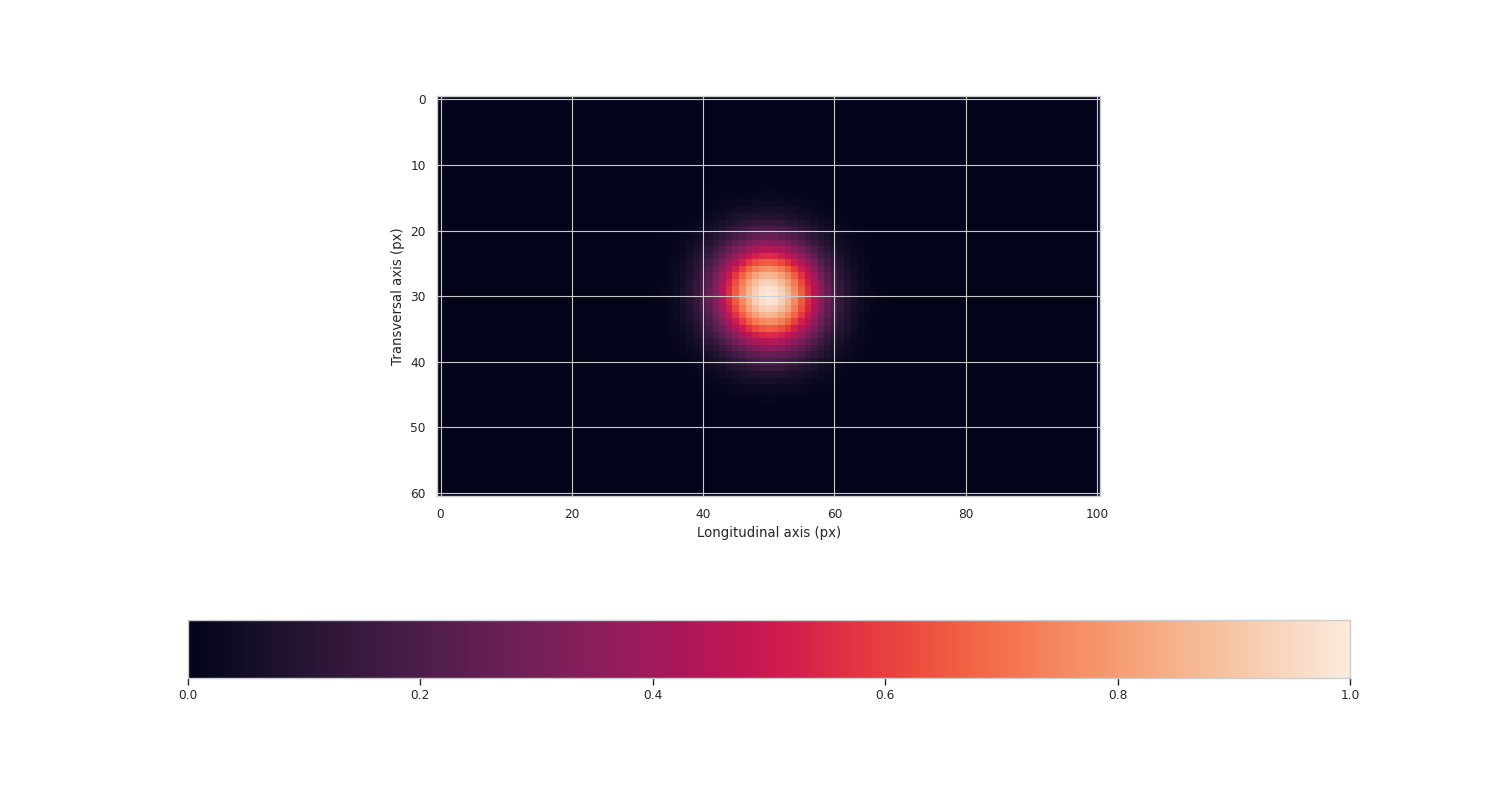

In [28]:
# Example usage:
dataset_path = '/home/lmmartinez/Tesis/datasets/highD/images/01_images.hdf5'  # Replace with the path to your HDF5 file
train_data, validation_data, test_data = load_hdf5_dataset(dataset_path)

fig = plt.figure(figsize=(15, 8))

#plot heatmap
ax2d = fig.add_subplot()
img = ax2d.imshow(train_data[8])
ax2d.set_xlabel("Longitudinal axis (px)")
ax2d.set_ylabel("Transversal axis (px)")
fig.colorbar(img, orientation = 'horizontal', pad = 0.2)

plt.show()